## Round 1 Model
- The goal of this notebook is to focus on creating the best model to predict the first round scores of the tournament
- First, features will be engineered based on previous work in the exploratory notebook.
- Then, there will be multiple models selected to minimize Mean Squared Error

In [37]:
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## database where clean data is stored
conn = sqlite3.connect('/Users/nickospelt/Documents/App_Projects/PGA_Score_Predictor/Data/PGA_SQL_DB/PGA.db')

## Prepare Data for Feature Importance and Model Development

In [11]:
round_one_query = """WITH 
TOURNAMENT_AVGS AS (
SELECT TOURNAMENT_NAME,
    AVG(R1_AVG_SCORE - PAR) AS R1_AVG_SCORE,
    AVG(R1_PUTTS) AS AVG_R1_PUTTS, 
    AVG(GIR_PERCENTAGE) AS AVG_GIR,
    AVG(SCRAMBLING_PERCENTAGE) AS AVG_SCRAMB,
    AVG(TOTAL_DRIVING_DISTANCE) AS AVG_DRIVE_DIST,
    AVG(FIR_PERCENTAGE) AS AVG_FIR
FROM PLAYER_TOURNAMENT_RESULTS_V2
GROUP BY 1
),
PLAYER_RATIOS AS (
SELECT PLAYER_TOURNAMENT_RESULTS_V2.TOURNAMENT_NAME, TOURNAMENT_DATE, PLAYER_NAME,
    (R1_SCORE - PAR), TOURNAMENT_AVGS.R1_AVG_SCORE, ((R1_SCORE - PAR) - TOURNAMENT_AVGS.R1_AVG_SCORE) / (TOURNAMENT_AVGS.R1_AVG_SCORE) AS R1_SCORE_RATIO,
    SCRAMBLING_PERCENTAGE, AVG_SCRAMB,(SCRAMBLING_PERCENTAGE - AVG_SCRAMB) / (AVG_SCRAMB) AS SCRAMB_RATIO,
    GIR_PERCENTAGE, AVG_GIR, (GIR_PERCENTAGE - AVG_GIR) / (AVG_GIR) AS GIR_RATIO,
    FIR_PERCENTAGE, AVG_FIR, (FIR_PERCENTAGE - AVG_FIR) / (AVG_FIR) AS FIR_RATIO,
    TOTAL_DRIVING_DISTANCE, AVG_DRIVE_DIST, (TOTAL_DRIVING_DISTANCE - AVG_DRIVE_DIST) / (AVG_DRIVE_DIST) AS DRIVE_DIST_RATIO, 
    R1_PUTTS, AVG_R1_PUTTS, (R1_PUTTS - AVG_R1_PUTTS) / (AVG_R1_PUTTS) AS R1_PUTT_RATIO
FROM PLAYER_TOURNAMENT_RESULTS_V2 LEFT JOIN TOURNAMENT_AVGS ON PLAYER_TOURNAMENT_RESULTS_V2.TOURNAMENT_NAME = TOURNAMENT_AVGS.TOURNAMENT_NAME
),
LAGGED_RATIOS AS (
SELECT TOURNAMENT_NAME, TOURNAMENT_DATE, PLAYER_NAME,
    LAG(R1_SCORE_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_R1_SCORE_RATIO,
    LAG(R1_SCORE_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_R1_SCORE_RATIO,
    LAG(R1_SCORE_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_R1_SCORE_RATIO,
    LAG(SCRAMB_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_SCRAMB_RATIO,
    LAG(SCRAMB_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_SCRAMB_RATIO,
    LAG(SCRAMB_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_SCRAMB_RATIO,
    LAG(DRIVE_DIST_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_DRIVE_DIST_RATIO,
    LAG(DRIVE_DIST_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_DRIVE_DIST_RATIO,
    LAG(DRIVE_DIST_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_DRIVE_DIST_RATIO,
    LAG(FIR_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_FIR_RATIO,
    LAG(FIR_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_FIR_RATIO,
    LAG(FIR_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_FIR_RATIO,
    LAG(GIR_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_GIR_RATIO,
    LAG(GIR_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_GIR_RATIO,
    LAG(GIR_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_GIR_RATIO,
    LAG(R1_PUTT_RATIO) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P1_R1_PUTT_RATIO,
    LAG(R1_PUTT_RATIO, 2) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P2_R1_PUTT_RATIO,
    LAG(R1_PUTT_RATIO, 3) OVER (PARTITION BY PLAYER_NAME ORDER BY TOURNAMENT_DATE) AS P3_R1_PUTT_RATIO
FROM PLAYER_RATIOS
),
WEIGHTS AS (
 SELECT *,
     (CASE
         WHEN P1_GIR_RATIO IS NULL THEN NULL
         WHEN P2_GIR_RATIO IS NULL THEN 1
         WHEN P3_GIR_RATIO IS NULL THEN 0.6
         ELSE 0.5
     END) AS WEIGHT_1,
     (CASE
         WHEN P1_GIR_RATIO IS NULL THEN NULL
         WHEN P2_GIR_RATIO IS NULL THEN 0
         WHEN P3_GIR_RATIO IS NULL THEN 0.4
         ELSE 0.3
     END) AS WEIGHT_2,
     (CASE
         WHEN P1_GIR_RATIO IS NULL THEN NULL
         WHEN P2_GIR_RATIO IS NULL THEN 0
         WHEN P3_GIR_RATIO IS NULL THEN 0
         ELSE 0.2
     END) AS WEIGHT_3
 FROM LAGGED_RATIOS
)

-- This weighted average computation is where it is not clear what the best way is to handle the time series component of the player statistics
SELECT WEIGHTS.TOURNAMENT_NAME, WEIGHTS.TOURNAMENT_DATE, WEIGHTS.PLAYER_NAME, PLAYER_ID,
    (CASE 
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%MASTERS%" THEN 1.0
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%U.S. OPEN%" THEN 2.0
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%THE OPEN%" THEN 3.0
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%PGA%" THEN 4.0
         WHEN UPPER(WEIGHTS.TOURNAMENT_NAME) LIKE "%PLAYERS%" THEN 5.0
     END) AS TOURNAMENT_F,
    R1_TEMP, R1_PRECIP, R1_WIND_SPEED, R1_WIND_DIRECT,
    ELEVATION, PAR, LENGTH,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_R1_SCORE_RATIO, 0) * WEIGHT_1 + IFNULL(P2_R1_SCORE_RATIO, 0) * WEIGHT_2 + IFNULL(P3_R1_SCORE_RATIO, 0) * WEIGHT_3
    END) AS R1_SCORE_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_SCRAMB_RATIO, 0) * WEIGHT_1 + IFNULL(P2_SCRAMB_RATIO, 0) * WEIGHT_2 + IFNULL(P3_SCRAMB_RATIO, 0) * WEIGHT_3
    END) AS SCRAMB_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_DRIVE_DIST_RATIO, 0) * WEIGHT_1 + IFNULL(P2_DRIVE_DIST_RATIO, 0) * WEIGHT_2 + IFNULL(P3_DRIVE_DIST_RATIO, 0) * WEIGHT_3
    END) AS DRIVE_DIST_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_FIR_RATIO, 0) * WEIGHT_1 + IFNULL(P2_FIR_RATIO, 0) * WEIGHT_2 + IFNULL(P3_FIR_RATIO, 0) * WEIGHT_3
    END) AS FIR_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_GIR_RATIO, 0) * WEIGHT_1 + IFNULL(P2_GIR_RATIO, 0) * WEIGHT_2 + IFNULL(P3_GIR_RATIO, 0) * WEIGHT_3
    END) AS GIR_RATIO,
    (CASE
        WHEN WEIGHT_1 IS NULL THEN NULL
        ELSE IFNULL(P1_R1_PUTT_RATIO, 0) * WEIGHT_1 + IFNULL(P2_R1_PUTT_RATIO, 0) * WEIGHT_2 + IFNULL(P3_R1_PUTT_RATIO, 0) * WEIGHT_3
    END) AS R1_PUTT_RATIO,
    R1_SCORE
FROM WEIGHTS INNER JOIN PLAYER_TOURNAMENT_RESULTS_V2 
    ON WEIGHTS.TOURNAMENT_NAME = PLAYER_TOURNAMENT_RESULTS_V2.TOURNAMENT_NAME AND WEIGHTS.PLAYER_NAME = PLAYER_TOURNAMENT_RESULTS_V2.PLAYER_NAME
WHERE GIR_RATIO IS NOT NULL
ORDER BY WEIGHTS.PLAYER_NAME, WEIGHTS.TOURNAMENT_DATE"""

round_one_df = pd.read_sql_query(round_one_query, conn)
round_one_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PLAYER_ID,TOURNAMENT_F,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R1_WIND_DIRECT,ELEVATION,PAR,LENGTH,R1_SCORE_RATIO,SCRAMB_RATIO,DRIVE_DIST_RATIO,FIR_RATIO,GIR_RATIO,R1_PUTT_RATIO,R1_SCORE
0,2023 THE PLAYERS Championship,2023-03-09,Aaron Baddeley,22371,5.0,65.2,0.000,10.6,73,6.0,72,7275,-0.534884,-0.047069,-0.030084,-0.009579,0.086637,-0.043000,73
1,2023 THE PLAYERS Championship,2023-03-09,Aaron Rai,46414,5.0,65.2,0.000,10.6,73,6.0,72,7275,-1.000000,0.097885,-0.032888,0.246699,0.006647,-0.083296,73
2,2019 PGA Championship,2019-05-16,Aaron Wise,49964,4.0,58.4,0.031,7.1,279,37.0,70,7459,-0.325843,-0.021406,0.025476,-0.033767,0.028812,0.083898,70
3,2019 U.S. Open,2019-06-13,Aaron Wise,49964,2.0,58.8,0.000,14.1,228,14.0,71,7075,-0.730337,-0.005897,0.012299,0.005793,0.010988,-0.027771,66
4,2019 The Open Championship,2019-07-18,Aaron Wise,49964,3.0,58.0,0.102,14.1,237,14.0,71,7344,-1.512837,-0.064794,0.023253,0.006270,0.023669,-0.073627,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2019 U.S. Open,2019-06-13,Zach Johnson,24024,2.0,58.8,0.000,14.1,228,14.0,71,7075,-1.008061,-0.106716,-0.032667,0.129486,-0.037551,-0.001100,70
1348,2021 THE PLAYERS Championship,2021-03-11,Zach Johnson,24024,5.0,63.2,0.000,9.5,92,6.0,72,7189,-0.979040,-0.031208,-0.040046,0.085905,-0.045309,0.033143,75
1349,2023 Masters Tournament,2023-04-06,Zach Johnson,24024,1.0,73.6,0.035,8.1,181,44.0,72,7545,-0.627480,0.032173,-0.036310,-0.010043,-0.042323,0.007209,75
1350,2023 PGA Championship,2023-05-18,Zach Johnson,24024,4.0,46.8,0.000,8.0,141,155.0,70,7394,-0.315716,-0.001358,-0.034478,-0.011113,0.025465,0.048872,74


### Feature Engineering Outside of SQL

In [12]:
def weather_weighted_average(temp, precip, wind_speed):
    weights = [0.2, 0.3, 0.5]
    return (temp * -1 * weights[0] + precip * weights[1] + wind_speed * weights[2])

scaler = StandardScaler()
round_one_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R1_WIND_DIRECT']] = scaler.fit_transform(round_one_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R1_WIND_DIRECT']])

round_one_df['R1_WEATHER_FACTOR'] = round_one_df.apply(lambda row:
    weather_weighted_average(row['R1_TEMP'], row['R1_PRECIP'], row['R1_WIND_SPEED']), axis=1)
round_one_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,PLAYER_ID,TOURNAMENT_F,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R1_WIND_DIRECT,ELEVATION,PAR,LENGTH,R1_SCORE_RATIO,SCRAMB_RATIO,DRIVE_DIST_RATIO,FIR_RATIO,GIR_RATIO,R1_PUTT_RATIO,R1_SCORE,R1_WEATHER_FACTOR
0,2023 THE PLAYERS Championship,2023-03-09,Aaron Baddeley,22371,5.0,-0.071384,-0.349479,-0.367575,-1.752225,6.0,72,7275,-0.534884,-0.047069,-0.030084,-0.009579,0.086637,-0.043000,73,-0.274355
1,2023 THE PLAYERS Championship,2023-03-09,Aaron Rai,46414,5.0,-0.071384,-0.349479,-0.367575,-1.752225,6.0,72,7275,-1.000000,0.097885,-0.032888,0.246699,0.006647,-0.083296,73,-0.274355
2,2019 PGA Championship,2019-05-16,Aaron Wise,49964,4.0,-0.992221,-0.138151,-1.381251,1.179223,37.0,70,7459,-0.325843,-0.021406,0.025476,-0.033767,0.028812,0.083898,70,-0.533627
3,2019 U.S. Open,2019-06-13,Aaron Wise,49964,2.0,-0.938054,-0.349479,0.646101,0.453476,14.0,71,7075,-0.730337,-0.005897,0.012299,0.005793,0.010988,-0.027771,66,0.405817
4,2019 The Open Championship,2019-07-18,Aaron Wise,49964,3.0,-1.046388,0.345859,0.646101,0.581549,14.0,71,7344,-1.512837,-0.064794,0.023253,0.006270,0.023669,-0.073627,72,0.636086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2019 U.S. Open,2019-06-13,Zach Johnson,24024,2.0,-0.938054,-0.349479,0.646101,0.453476,14.0,71,7075,-1.008061,-0.106716,-0.032667,0.129486,-0.037551,-0.001100,70,0.405817
1348,2021 THE PLAYERS Championship,2021-03-11,Zach Johnson,24024,5.0,-0.342219,-0.349479,-0.686159,-1.481849,6.0,72,7189,-0.979040,-0.031208,-0.040046,0.085905,-0.045309,0.033143,75,-0.379480
1349,2023 Masters Tournament,2023-04-06,Zach Johnson,24024,1.0,1.066120,-0.110883,-1.091630,-0.215349,44.0,72,7545,-0.627480,0.032173,-0.036310,-0.010043,-0.042323,0.007209,75,-0.792304
1350,2023 PGA Championship,2023-05-18,Zach Johnson,24024,4.0,-2.563060,-0.349479,-1.120592,-0.784563,155.0,70,7394,-0.315716,-0.001358,-0.034478,-0.011113,0.025465,0.048872,74,-0.152528


### Identify Feature and Target to be used in Train/Test for Feature Importance

In [24]:
round_one_features = ['PLAYER_ID', 'TOURNAMENT_F', 'R1_WEATHER_FACTOR', 'ELEVATION', 'PAR', 'LENGTH', 'R1_SCORE_RATIO', 'SCRAMB_RATIO', 'DRIVE_DIST_RATIO', 'FIR_RATIO', 'GIR_RATIO', 'R1_PUTT_RATIO']
round_one_target = 'R1_SCORE'
round_one_feaures_and_target = ['PLAYER_ID', 'TOURNAMENT_F', 'R1_WEATHER_FACTOR', 'ELEVATION', 'PAR', 'LENGTH', 'R1_SCORE_RATIO', 'SCRAMB_RATIO', 'DRIVE_DIST_RATIO', 'FIR_RATIO', 'GIR_RATIO', 'R1_PUTT_RATIO', 'R1_SCORE']

In [38]:
X = round_one_df[round_one_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = round_one_df[round_one_target]

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_scaled, columns=round_one_features), y, test_size=0.2)

## Feature Importance and Selection

### Create a Correlation Map To Determine Which Factors Are Correlated to Each Other

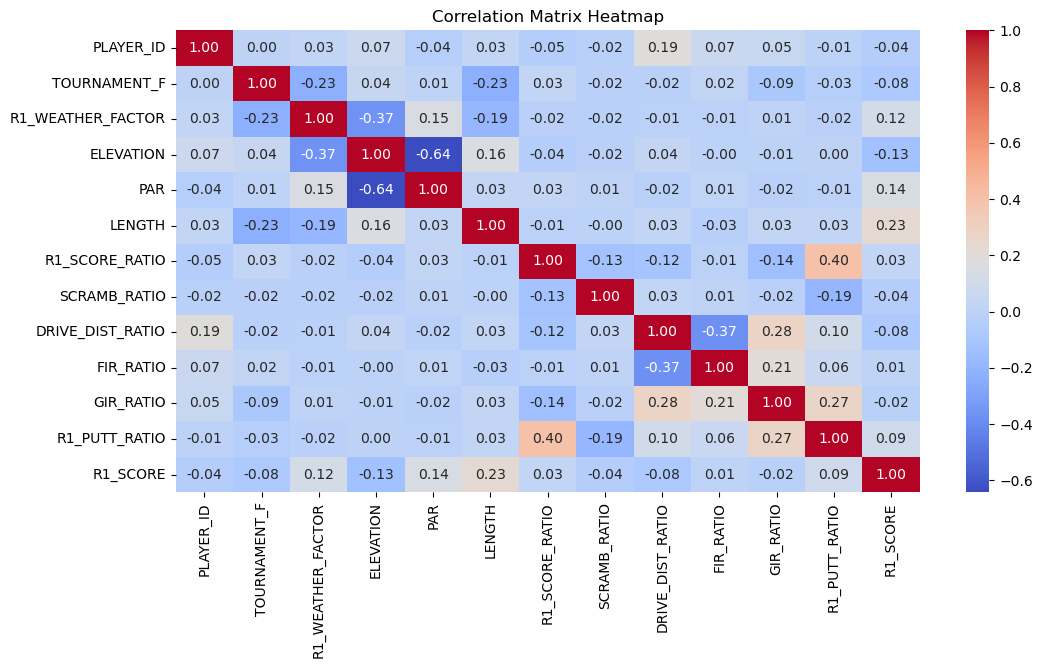

In [25]:
# Compute correlation matrix
correlation_matrix = round_one_df[round_one_feaures_and_target].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Takeaways
- Elevation is highly correlated with the weather. Is there a way to combine this into the weather factor?
- The player statistic ratios are correlated with each other. This proves the basis on which strokes gained was created. May need to transition to those statistics opposed to straight percentages.
- Also, the ratios are not highly correlated to the round score. Is this due to the way in which ratios are derived based on historical data? (weighted average of previous scores (max of previous 3))


### Linear Regression for Feature Importance

In [39]:
linear_regression_model = LinearRegression()

# Train the model
linear_regression_model.fit(X_train, y_train)

# Training Stats
y_train_predict = linear_regression_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
r2_train = r2_score(y_train, y_train_predict)

# Testing Stats
y_test_predict = linear_regression_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_predict)
mae_test = mean_absolute_error(y_test, y_test_predict)
r2_test = r2_score(y_test, y_test_predict)

# Training and Test Performance
print(f"Training: MSE: {mse_train}, MAE: {mae_train}, R^2: {r2_train}")
print(f"Testing: MSE: {mse_test}, MAE: {mae_test}, R^2: {r2_test}")

# Feature Importance
coefficients = linear_regression_model.coef_
round_1 = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficients': coefficients,
}).sort_values(by=['Coefficients'], ascending=False)
print("FEATURES:")
print(round_1)

Training: MSE: 5.8807295203060965, MAE: 1.9466058369187624, R^2: 0.11473484406863677
Testing: MSE: 5.66178947120518, MAE: 1.8882052992284317, R^2: 0.08509179599810845
FEATURES:
              Feature  Coefficients
5              LENGTH      0.625708
11      R1_PUTT_RATIO      0.356932
2   R1_WEATHER_FACTOR      0.314804
4                 PAR      0.163991
9           FIR_RATIO      0.036280
1        TOURNAMENT_F     -0.038857
6      R1_SCORE_RATIO     -0.090838
0           PLAYER_ID     -0.107732
3           ELEVATION     -0.144985
7        SCRAMB_RATIO     -0.152939
8    DRIVE_DIST_RATIO     -0.188946
10          GIR_RATIO     -0.202346


- This echos what was seen in the correlation map. Length with the largest correlation and by far the largest coefficent.
- For these results to improve need to decrease the correlation between features and revisit how the ratios are calculated historically

### Decision Tree for Feature Importance

In [41]:
random_forrest_model = RandomForestClassifier()
random_forrest_model.fit(X_train, y_train)

# Training Stats
y_train_predict = random_forrest_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
r2_train = r2_score(y_train, y_train_predict)

# Testing Stats
y_test_predict = random_forrest_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_predict)
mae_test = mean_absolute_error(y_test, y_test_predict)
r2_test = r2_score(y_test, y_test_predict)

# Training and Test Performance
print(f"Training: MSE: {mse_train}, MAE: {mae_train}, R^2: {r2_train}")
print(f"Testing: MSE: {mse_test}, MAE: {mae_test}, R^2: {r2_test}")

feature_importances = pd.DataFrame({
    "Feature": round_one_features,
    "Importance": random_forrest_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importances)

Training: MSE: 0.0, MAE: 0.0, R^2: 1.0
Testing: MSE: 7.313653136531365, MAE: 2.1180811808118083, R^2: -0.18183858475620474
              Feature  Importance
8    DRIVE_DIST_RATIO    0.119260
7        SCRAMB_RATIO    0.119019
9           FIR_RATIO    0.116221
10          GIR_RATIO    0.113966
11      R1_PUTT_RATIO    0.113398
6      R1_SCORE_RATIO    0.111642
0           PLAYER_ID    0.110246
2   R1_WEATHER_FACTOR    0.061240
5              LENGTH    0.050411
3           ELEVATION    0.038864
1        TOURNAMENT_F    0.025401
4                 PAR    0.020333


- A good sign here that the ratios are the most important features.
- Interested to see how this improves once fix the previous issues.